In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, EvalPrediction
import evaluate
import torch

%matplotlib inline

In [2]:
# Load split data
train_df = pd.read_csv("./data/alpha_vantage_train.csv")
test_df = pd.read_csv("./data/alpha_vantage_test.csv")

In [3]:
from datasets import Dataset, concatenate_datasets

ds_train = Dataset.from_pandas(train_df)
ds_test = Dataset.from_pandas(test_df)

In [4]:
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 16688
})

In [5]:
def over_sample(ds, target_size):
    curr_ds = ds
    while curr_ds.shape[0] < target_size:
        curr_ds = concatenate_datasets([curr_ds, ds])
    return curr_ds.shuffle(seed=42)

ds_sub = ds_train.shuffle()

Text(0.5, 1.0, 'Dataset size: 16688')

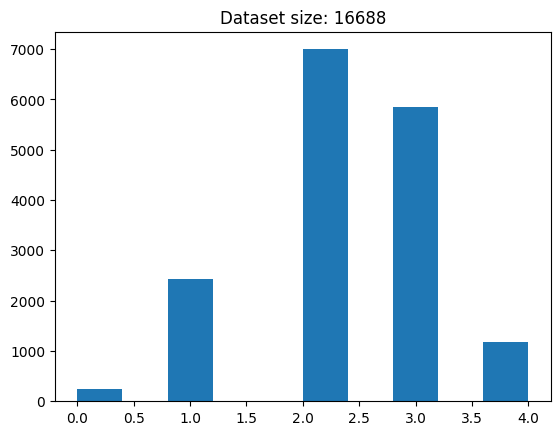

In [6]:
_ = plt.hist(ds_sub['label'])
plt.title(f'Dataset size: {ds_sub.shape[0]}')

In [7]:
torch.cuda.empty_cache()
print(f'CUDA: {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device}')

_, cts = np.unique(ds_train['label'], return_counts=True)
class_weights = 1.0 / cts
class_weights /= class_weights.sum()
print(class_weights)
class_weights = torch.Tensor(class_weights).to(device)

CUDA: True
DEVICE: cuda:0
[0.72971709 0.07080244 0.02451165 0.02927339 0.14569543]


Loading Bert model

In [8]:
MODEL_NAME = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize(datapoint):
    return tokenizer(datapoint['text'], padding='max_length', truncation=True)


tokenized_train_df = ds_sub.map(tokenize, batched=True)
tokenized_test_df = ds_test.map(tokenize, batched=True)

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/16688 [00:00<?, ? examples/s]

Map:   0%|          | 0/7152 [00:00<?, ? examples/s]

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [10]:
training_args = TrainingArguments(
    output_dir="chkpt_bert_uncased",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
)

metric = evaluate.load("accuracy")

In [20]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    y_pred = np.argmax(logits, axis=-1)
    return metric.compute(predictions=y_pred, references=labels)

In [21]:
# from torch import nn
# 
#  For trainig with class weights
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.get("labels")
#         # forward pass
#         outputs = model(**inputs)
#         logits = outputs.get('logits')
#         # compute custom loss
#         loss_fct = nn.CrossEntropyLoss(weight=class_weights)
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_df,
    eval_dataset=tokenized_test_df,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.478500,1.037215,0.635207
2,0.277900,1.369967,0.620526
3,0.215000,1.582023,0.630593
4,0.131800,2.149369,0.633389
5,0.058400,2.413528,0.631991


TrainOutput(global_step=5215, training_loss=0.23646719028257113, metrics={'train_runtime': 3496.4415, 'train_samples_per_second': 23.864, 'train_steps_per_second': 1.492, 'total_flos': 2.195457780719616e+16, 'train_loss': 0.23646719028257113, 'epoch': 5.0})

In [22]:
# Define the evaluation metric
def eval_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    report = classification_report(p.label_ids, preds)
    print(report)
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc}


# Define training arguments
eval_args = TrainingArguments(
    output_dir="./results_bert",
    do_train=False,
    do_eval=True,
    per_device_eval_batch_size=16,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_test_df,
    compute_metrics=eval_metrics,
)

# Run evaluation
eval_result = trainer.evaluate()

# Print results
print(eval_result)

              precision    recall  f1-score   support

           0       0.50      0.18      0.27        94
           1       0.60      0.56      0.58      1089
           2       0.64      0.67      0.65      3004
           3       0.65      0.67      0.66      2492
           4       0.57      0.47      0.52       473

    accuracy                           0.63      7152
   macro avg       0.59      0.51      0.53      7152
weighted avg       0.63      0.63      0.63      7152

{'eval_loss': 2.4135284423828125, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.6319910514541387, 'eval_runtime': 86.8152, 'eval_samples_per_second': 82.382, 'eval_steps_per_second': 5.149}


### BERT-cased

In [11]:
MODEL_NAME = "google-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize(datapoint):
    return tokenizer(datapoint['text'], padding='max_length', truncation=True)


tokenized_train_df = ds_sub.map(tokenize, batched=True)
tokenized_test_df = ds_test.map(tokenize, batched=True)

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/16688 [00:00<?, ? examples/s]

Map:   0%|          | 0/7152 [00:00<?, ? examples/s]

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)

training_args = TrainingArguments(
    output_dir="bert_cased_chkpt",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    y_pred = np.argmax(logits, axis=-1)
    return metric.compute(predictions=y_pred, references=labels)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_df,
    eval_dataset=tokenized_test_df,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.002300,0.836545,0.649085
2,0.757000,0.897422,0.650771
3,0.524300,1.055685,0.673892
4,0.333900,1.405493,0.667148
5,0.105200,1.702650,0.676541


TrainOutput(global_step=3030, training_loss=0.48341082527299134, metrics={'train_runtime': 2073.8636, 'train_samples_per_second': 23.357, 'train_steps_per_second': 1.461, 'total_flos': 1.274544282095616e+16, 'train_loss': 0.48341082527299134, 'epoch': 5.0})

In [38]:
# Define the evaluation metric
def eval_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    report = classification_report(p.label_ids, preds)
    print(report)
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc}


# Define training arguments
eval_args = TrainingArguments(
    output_dir="./results_bert",
    do_train=False,
    do_eval=True,
    per_device_eval_batch_size=16,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_test_df,
    compute_metrics=eval_metrics,
)

# Run evaluation
eval_result = trainer.evaluate()

# Print results
print(eval_result)

              precision    recall  f1-score   support

           0       0.31      0.21      0.25        76
           1       0.74      0.74      0.74      1075
           2       0.64      0.68      0.66      1520
           3       0.68      0.67      0.68      1239
           4       0.69      0.55      0.61       242

    accuracy                           0.68      4152
   macro avg       0.61      0.57      0.59      4152
weighted avg       0.68      0.68      0.68      4152

{'eval_loss': 1.7026499509811401, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.6765414258188824, 'eval_runtime': 49.7945, 'eval_samples_per_second': 83.383, 'eval_steps_per_second': 5.221}
